#拍照用
from PIL import Image as PIL_Image
import cv2
import matplotlib.pyplot as plt
import numpy as np
orig_img_path = 'data/plate10.jpg'
!fswebcam  --no-banner --save {orig_img_path} -d /dev/video0 2> /dev/null

# img = PIL_Image.open(orig_img_path)
# img
img=cv2.imread(orig_img_path)

In [1]:
import os
patternsPath = 'solid_patterns/'
extension = '.jpg'

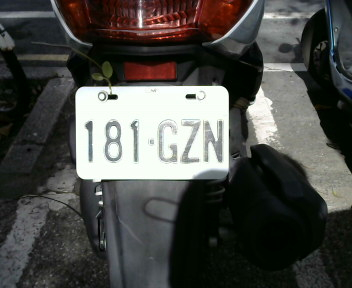

In [12]:
#之前的照片 

from PIL import Image as PIL_Image
import cv2
import matplotlib.pyplot as plt
import numpy as np
import easyocr
import pytesseract
orig_img_path = 'data/plate4.jpg'
img=cv2.imread(orig_img_path)
img0 = PIL_Image.open(orig_img_path)
img0

In [13]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cv2.imwrite("output/output0.jpg",gray)
# cv2.imshow("gray",gray)
# cv2.waitKey(0)
# cv2.destoryAllWindows()

True

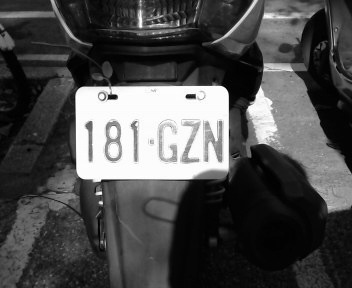

In [14]:
gray_img_path = 'output/output0.jpg'
img1 = PIL_Image.open(gray_img_path)
img1

In [15]:
x = cv2.Sobel(gray, cv2.CV_16S, 1, 0)      # 偵測邊緣
y = cv2.Sobel(gray, cv2.CV_16S, 0, 1)      # 偵測邊緣
absx=cv2.convertScaleAbs(x)
absy=cv2.convertScaleAbs(y)
dst=cv2.addWeighted(absx,0.8,absy,0.2,0)
cv2.imwrite("output/output1.jpg",dst)

True

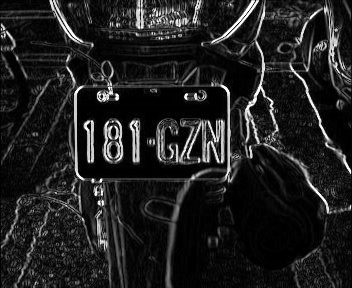

In [16]:
sobel_img_path = 'output/output1.jpg'
img2 = PIL_Image.open(sobel_img_path)
img2

In [17]:
# 對灰度圖像進行二值化
ret, thresh = cv2.threshold(dst, 200, 255, cv2.THRESH_BINARY)
cv2.imwrite("output/output2.jpg",thresh)

True

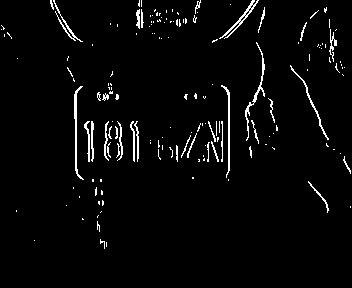

In [18]:
thresh_img_path = 'output/output2.jpg'
img3 = PIL_Image.open(thresh_img_path)
img3

In [19]:
# 對二值化圖像進行形態學處理
kernelx = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 1))
kernely = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 30))
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (20, 2))

morph = cv2.dilate(thresh, kernelx)
morph = cv2.erode(morph, kernelx)

morph = cv2.erode(morph, kernely)
morph = cv2.dilate(morph, kernely)

morph = cv2.erode(morph, kernel)
# morph = cv2.dilate(morph, kernel)

cv2.imshow("windows", morph)
key = cv2.waitKey(0)
cv2.destroyWindow("windows")

morph = cv2.medianBlur(morph, 31)

cv2.imwrite("output/output3.jpg",morph)

True

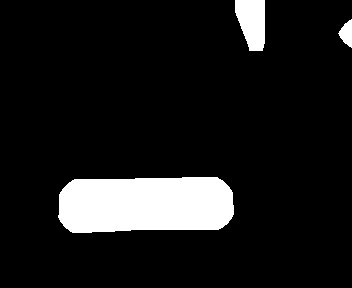

In [10]:
morph_img_path = 'output/output3.jpg'
img4 = PIL_Image.open(morph_img_path)
img4

In [58]:
contours, hierarchy = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]
max_weight=0
for item in contours:
    x,y,weight,height = cv2.boundingRect(item)
    print(x,y,weight,height)    
    if (weight / height > 1.5) and (weight>max_weight):
        max_weight=weight
        crop_img = gray[y-20:y + height + 15, x - 5:x + weight+15]    
cv2.imwrite("output/output4.jpg",crop_img)

86 123 44 40
208 117 36 37
341 34 11 35
273 82 16 1


True

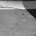

In [59]:
crop_img_path = 'output/output4.jpg'
img5 = PIL_Image.open(crop_img_path)
img5
# print(contours)q
# print(hierarchy)

In [60]:
#车牌字符分割
#图像去噪灰度处理
plate = cv2.GaussianBlur(crop_img, (3, 3), 0)
# plate = cv2.cvtColor(plate, cv2.COLOR_RGB2GRAY)
# 图像阈值化操作——获得二值化图   
ret, plate = cv2.threshold(plate, 0, 255, cv2.THRESH_OTSU)

#膨胀操作
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,1))
plate = cv2.dilate(plate, kernel)
# plate = cv2.dilate(plate, kernel)
# plate = cv2.dilate(plate, kernel)
# plate = cv2.erode(plate, kernel)


#黑白反轉
plate=255-plate
cv2.imwrite("output/output5.jpg",plate)

True

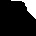

In [61]:
plate_path = 'output/output5.jpg'
img6 = PIL_Image.open(plate_path)
img6

In [62]:
#easyOCR字元辨識
reader = easyocr.Reader(['en'])
result = reader.readtext('output/output5.jpg',detail=0)
print(result)

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


[]


In [34]:
#tesseract字元辨識
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\\tesseract.exe'
plate0 = PIL_Image.open('output/output5.jpg')
result = pytesseract.image_to_string(plate0, lang='eng')
print(result)

MBW-2589}



In [35]:
# 查找轮廓
contours, hierarchy = cv2.findContours(plate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
words = []
word_images = []
# cv2.drawContours(plate,contours,-1,(150,150,0),1)
#对所有轮廓逐一操作
for item in contours:
    word = []
    rect = cv2.boundingRect(item)
    x = rect[0]
    y = rect[1]
    weight = rect[2]
    height = rect[3]
    word.append(x)
    word.append(y)
    word.append(weight)
    word.append(height)
    words.append(word)
#     cv2.rectangle(plate,(x,y),(x+weight,y+height),(150,150,0),1)
    
# 排序，车牌号有顺序。words是一个嵌套列表
words = sorted(words,key=lambda s:s[0],reverse=False)
i = 0
# word中存放轮廓的起始点和宽高
for word in words:
    # 筛选字符的轮廓
    if (word[3]>(plate.shape[0]*0.45)) and (word[3]/word[2]>1.5) and (word[3]<(plate.shape[0]*0.9)):
        i = i+1
        splite_image = plate[word[1]:word[1] + word[3], word[0] :word[0] + word[2] + 2]
        splite_image=255-splite_image
        word_images.append(splite_image)
        print(word)
    
cv2.imwrite('output/word0.jpg',word_images[0])
cv2.imwrite('output/word1.jpg',word_images[1])
cv2.imwrite('output/word2.jpg',word_images[2])
cv2.imwrite('output/word3.jpg',word_images[3])
cv2.imwrite('output/word4.jpg',word_images[4])
cv2.imwrite('output/word5.jpg',word_images[5])
cv2.imwrite('output/word6.jpg',word_images[6])

    
    

# idx=10
# plate_word0=plate[words[idx][1]:words[idx][1]+words[idx][3],words[idx][0]:words[idx][0]+words[idx][2]]
# cv2.imwrite("output6.jpg",plate_word0)


[3, 22, 17, 43]
[23, 21, 17, 43]
[43, 20, 16, 42]
[70, 19, 17, 41]
[89, 18, 17, 41]
[109, 18, 16, 40]
[128, 18, 15, 39]


True

In [36]:
plate_word0_path = 'output/word0.jpg'
img7 = PIL_Image.open(plate_word0_path)
img7

In [37]:
plate_word1_path = 'output/word1.jpg'
img7 = PIL_Image.open(plate_word1_path)
img7

In [38]:
plate_word2_path = 'output/word2.jpg'
img7 = PIL_Image.open(plate_word2_path)
img7

In [39]:
plate_word3_path = 'output/word3.jpg'
img7 = PIL_Image.open(plate_word3_path)
img7

In [40]:
plate_word4_path = 'output/word4.jpg'
img7 = PIL_Image.open(plate_word4_path)
img7

In [41]:
plate_word5_path = 'output/word5.jpg'
img7 = PIL_Image.open(plate_word5_path)
img7

In [42]:
plate_word6_path = 'output/word6.jpg'
img7 = PIL_Image.open(plate_word6_path)
img7

In [43]:
# 匹配車牌文字 Matching License Plate Number cv2.TM_SQDIFF
results = []
for word_image in word_images:
    best_score = []
    patterns = os.listdir(patternsPath)
    for filename in patterns:  # 讀取資料夾下所有的圖片
        ret, pattern_img = cv2.threshold(cv2.cvtColor(cv2.imdecode(np.fromfile(patternsPath + filename, dtype=np.uint8), 1), cv2.COLOR_RGB2GRAY), 0, 255, cv2.THRESH_OTSU)  # 將範本進行格式轉換，再獲得Binary圖
        pattern_img = cv2.resize(pattern_img, (word_image.shape[1], word_image.shape[0]))  # 將範本resize至與圖像一樣大小
        best_score.append(cv2.matchTemplate(word_image, pattern_img, cv2.TM_SQDIFF)[0][0])  # 範本匹配，返回匹配得分
    i = best_score.index(min(best_score))  # 取得最高分的index
    print(i)
    results.append(patterns[i])
print("".join(results).replace(extension, ""))  # Printing Rusults To Console

22
8
23
35
5
8
9
M8NZ589


In [44]:
# 匹配車牌文字 Matching License Plate Number cv2.TM_SQDIFF_NORMED
results = []
for word_image in word_images:
    best_score = []
    patterns = os.listdir(patternsPath)
    for filename in patterns:  # 讀取資料夾下所有的圖片
        ret, pattern_img = cv2.threshold(cv2.cvtColor(cv2.imdecode(np.fromfile(patternsPath + filename, dtype=np.uint8), 1), cv2.COLOR_RGB2GRAY), 0, 255, cv2.THRESH_OTSU)  # 將範本進行格式轉換，再獲得Binary圖
        pattern_img = cv2.resize(pattern_img, (word_image.shape[1], word_image.shape[0]))  # 將範本resize至與圖像一樣大小
        best_score.append(cv2.matchTemplate(word_image, pattern_img, cv2.TM_SQDIFF_NORMED)[0][0])  # 範本匹配，返回匹配得分
    i = best_score.index(min(best_score))  # 取得最高分的index
    results.append(patterns[i])
print("".join(results).replace(extension, ""))  # Printing Rusults To Console

MPWZ5H9


In [45]:
# 匹配車牌文字 Matching License Plate Number CCORR
results = []
for word_image in word_images:
    best_score = []
    patterns = os.listdir(patternsPath)
    for filename in patterns:  # 讀取資料夾下所有的圖片
        ret, pattern_img = cv2.threshold(cv2.cvtColor(cv2.imdecode(np.fromfile(patternsPath + filename, dtype=np.uint8), 1), cv2.COLOR_RGB2GRAY), 0, 255, cv2.THRESH_OTSU)  # 將範本進行格式轉換，再獲得Binary圖
        pattern_img = cv2.resize(pattern_img, (word_image.shape[1], word_image.shape[0]))  # 將範本resize至與圖像一樣大小
        best_score.append(cv2.matchTemplate(word_image, pattern_img, cv2.TM_CCORR)[0][0])  # 範本匹配，返回匹配得分
    i = best_score.index(max(best_score))  # 取得最高分的index
    results.append(patterns[i])
print("".join(results).replace(extension, ""))  # Printing Rusults To Console

HLHZ5L9


In [46]:
# 匹配車牌文字 Matching License Plate Number cv2.TM_CCORR_NORMED
results = []
for word_image in word_images:
    best_score = []
    patterns = os.listdir(patternsPath)
    for filename in patterns:  # 讀取資料夾下所有的圖片
        ret, pattern_img = cv2.threshold(cv2.cvtColor(cv2.imdecode(np.fromfile(patternsPath + filename, dtype=np.uint8), 1), cv2.COLOR_RGB2GRAY), 0, 255, cv2.THRESH_OTSU)  # 將範本進行格式轉換，再獲得Binary圖
        pattern_img = cv2.resize(pattern_img, (word_image.shape[1], word_image.shape[0]))  # 將範本resize至與圖像一樣大小
        best_score.append(cv2.matchTemplate(word_image, pattern_img, cv2.TM_CCORR_NORMED)[0][0])  # 範本匹配，返回匹配得分
    i = best_score.index(max(best_score))  # 取得最高分的index
    results.append(patterns[i])
print("".join(results).replace(extension, ""))  # Printing Rusults To Console

MPWZ5H9


In [47]:
# 匹配車牌文字 Matching License Plate Number cv2.TM_CCOEFF
results = []
for word_image in word_images:
    best_score = []
    patterns = os.listdir(patternsPath)
    for filename in patterns:  # 讀取資料夾下所有的圖片
        ret, pattern_img = cv2.threshold(cv2.cvtColor(cv2.imdecode(np.fromfile(patternsPath + filename, dtype=np.uint8), 1), cv2.COLOR_RGB2GRAY), 0, 255, cv2.THRESH_OTSU)  # 將範本進行格式轉換，再獲得Binary圖
        pattern_img = cv2.resize(pattern_img, (word_image.shape[1], word_image.shape[0]))  # 將範本resize至與圖像一樣大小
        best_score.append(cv2.matchTemplate(word_image, pattern_img, cv2.TM_CCOEFF)[0][0])  # 範本匹配，返回匹配得分
    i = best_score.index(max(best_score))  # 取得最高分的index
    results.append(patterns[i])
print("".join(results).replace(extension, ""))  # Printing Rusults To Console

M0WZ589


In [48]:
# 匹配車牌文字 Matching License Plate Number  cv2.TM_CCOEFF_NORMED
results = []
for word_image in word_images:
    best_score = []
    patterns = os.listdir(patternsPath)
    for filename in patterns:  # 讀取資料夾下所有的圖片
        ret, pattern_img = cv2.threshold(cv2.cvtColor(cv2.imdecode(np.fromfile(patternsPath + filename, dtype=np.uint8), 1), cv2.COLOR_RGB2GRAY), 0, 255, cv2.THRESH_OTSU)  # 將範本進行格式轉換，再獲得Binary圖
        pattern_img = cv2.resize(pattern_img, (word_image.shape[1], word_image.shape[0]))  # 將範本resize至與圖像一樣大小
        best_score.append(cv2.matchTemplate(word_image, pattern_img, cv2.TM_CCOEFF_NORMED)[0][0])  # 範本匹配，返回匹配得分
    i = best_score.index(max(best_score))  # 取得最高分的index
    results.append(patterns[i])
print("".join(results).replace(extension, ""))  # Printing Rusults To Console

MPWZ589
